# Time-series prediction with Keras `SimpleRNN` class
### Dr. Tirthajyoti Sarkar, Fremont, CA 94536 ([LinkedIn](https://www.linkedin.com/in/tirthajyoti-sarkar-2127aa7/), [Github](https://tirthajyoti.github.io))

For more tutorial-style notebooks on deep learning, **[here is my Github repo](https://github.com/tirthajyoti/Deep-learning-with-Python)**.

For more tutorial-style notebooks on general machine learning, **[here is my Github repo](https://github.com/tirthajyoti/Machine-Learning-with-Python)**.

---
### What is this Notebook about?
In this notebook, we show a building simple recurrent neural network (RNN) using Keras.

We will generate some synthetic time-series data by multiplying two periodic/ sinusoidal signals and adding some stochasticity (Gaussian noise). Then, we will take a small fraction of the data and train a simple RNN model with it and try to predict the rest of the data and see how the predictions match up with the ground truth.

In [32]:
'''
Las RNN son RRNN especializadas en series temporales y en tratamiento de texto.
Llevan un encoding interno de los timestamps utilizados.
LSTM: Long Sort Memory Layer. Son capas capaces de trabajar con secuencias de datos.
Muy útiles para vídeo o speech recognition. Las neuronas tienen una memoria de los
valores anteriores.
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

In [33]:
# Total time points
N = 3004

# Time point to partition train/test splits.
# 25% of data (754) for TRAIN and the rest for test
Tp = 754   

np.random.seed(0)
t=np.arange(0,N)
x=(2*np.sin(0.02*t)*np.sin(0.003*t))+0.5*np.random.normal(size=N)
df = pd.DataFrame(x, columns=['Data'])
print(len(df))
df.head()

3004


,Data
0,0.882026
1,0.200199
2,0.489849
3,1.121526
4,0.935697


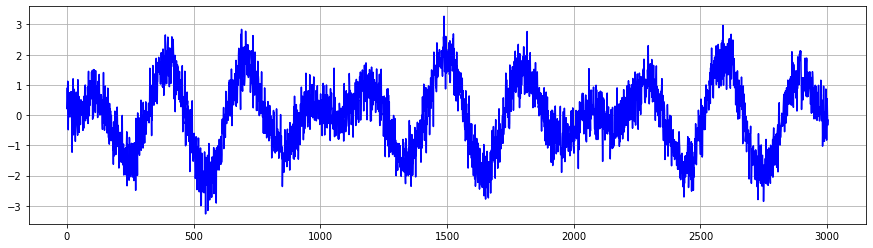

In [34]:
# Esta tendencia no va a ser sencilla de conseguir.
# En general bien, pero hay algunas partes raras que no siguen la tendencia, debido al ruido gausiano
plt.figure(figsize=(15,4))
plt.plot(df,c='blue')
plt.grid(True);

### Split the values in train and test

So, we took only 25% of the data as training samples and set aside the rest of the data for testing. 

Looking at the time-series plot, we think **it is not easy for a standard model to come up with correct trend predictions.**

In [35]:
values = df.values
# Train hasta Tp, hasta 754
train, test = values[0:Tp ,:], values[Tp:N,:]

In [36]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (754, 1)
Test data length: (2250, 1)


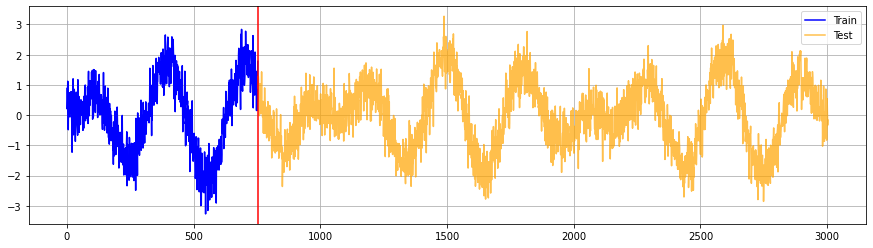

In [37]:
index = df.index.values
plt.figure(figsize=(15,4))
plt.plot(index[0:Tp],train,c='blue')
plt.plot(index[Tp:N],test,c='orange',alpha=0.7)
plt.legend(['Train','Test'])
plt.axvline(Tp, c="r")
plt.grid(True);

### Step (or _embedding_)
RNN model requires a step value that contains n number of elements as an input sequence.

Suppose x = {1,2,3,4,5,6,7,8,9,10}

for step=1, x input  and its y prediction become:

| x  | y  |
|---|---|
| 1  | 2  |
| 2  | 3  |
| 3  | 4  |
| ...  | ...  |
| 9  | 10  |

for step=3, x and y contain:

| x  | y  |
|---|---|
| 1,2,3  | 4  |
| 2,3,4  | 5  |
| 3,4,5  | 6  |
| ...  | ...  |
| 7,8,9  | 10  |

Here, we choose `step=4`. In more complex RNN and in particular for text processing, this is also called _embedding size_.

In [38]:
'''
Básicamente los steps son el número de lags necesarios para realizar las predicciones
Escogemos 4 lags.
Se los añade al final repetidos porque luego los eliminará al principio, ya que no puede
hacer las predicciones de los lags 1,2,3
'''
train.shape

(754, 1)

In [39]:
df2 = df.copy()
emb_size = 4

'''
Montamos nuevas features con los lags
'''
for i in range(1, emb_size+1):
    df2['lag' + str(i)] = df2['Data'].shift(i)
    
df2.dropna(inplace=True)
df2.reset_index(drop=True, inplace=True)

values = df2.values

'''
Volvemos a montar xtrain, xtest...
'''
trainX,trainY = values[0:Tp-emb_size ,1:],values[0:Tp-emb_size ,0],
testX,testY = values[Tp-emb_size:N-emb_size,1:], values[Tp-emb_size:N-emb_size,0]

print("Train data length:", trainX.shape)
print("Train target length:", trainY.shape)
print("Test data length:", testX.shape)
print("Test target length:", testY.shape)

Train data length: (750, 4)
Train target length: (750,)
Test data length: (2250, 4)
Test target length: (2250,)


In [40]:
df2.head()

,Data,lag1,lag2,lag3,lag4
0,0.935697,1.121526,0.489849,0.200199,0.882026
1,-0.485644,0.935697,1.121526,0.489849,0.200199
2,0.479354,-0.485644,0.935697,1.121526,0.489849
3,-0.069818,0.479354,-0.485644,0.935697,1.121526
4,-0.043963,-0.069818,0.479354,-0.485644,0.935697


In [41]:
'''
750 son los instantes para entrenar (eq a nº muestras)
1 x 4 dimensiones de estos dato, como una imagen. Si fuesen mas variables el 1 seria 2 o 3??
1 es una fila de datos, necesita ese formato
4 los lags para la capa LSTM
'''
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX.shape

(750, 1, 4)

In [42]:
trainX[:3]

array([[[ 1.12152594,  0.48984886,  0.2001986 ,  0.88202617]],

       [[ 0.9356969 ,  1.12152594,  0.48984886,  0.2001986 ]],

       [[-0.48564405,  0.9356969 ,  1.12152594,  0.48984886]]])

Para entrenar el modelo, necesito que los datos tengan la siguiente dimensión:

(750, 1, 4)

- 750: el número total de trozos 
- 1: una fila de datos
- 4: cada trozo tiene cuatro valores

En el caso de una imagen, recordemos con un ejemplo: 

(750, 28, 28)

750 imágenes de resolución 28x28

In [43]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (750, 1, 4) ,  (750,)
Test data shape: (2250, 1, 4) ,  (2250,)


### Keras model

- 256 neurons in the RNN layer
- 32 neurons in the densely connected layer
- A single neuron for the output layer. Predict a single number
- ReLu activation
- learning rate: 0.001

In [47]:
from tensorflow.keras.layers import Dense, LSTM
'''
embedding es la cantidad de lags utilizada
'''
def build_simple_rnn(num_units=128, embedding=4,num_dense=32,lr=0.001):
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    # Long short term memory
    # Esto es capa de entrada + capa con 128 neuronas con su función de activacion
    model.add(LSTM(units=num_units, input_shape=(1,embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
                  #optimizer=RMSprop(lr=lr),
                  optimizer='adam',
                  metrics=['mse'])
    
    return model

In [48]:
model = build_simple_rnn() # Taking the defaults
#model.save("my_model.h5")

NotImplementedError: Cannot convert a symbolic Tensor (lstm_1/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [46]:
'''
Parameters LSTM: 4(nm+n**2+n)
siendo n = nº neuronas y m = embeddings
'''
model.summary()

NameError: name 'model' is not defined

### A simple callback class to show a message every 50 epochs

In [16]:
'''
Enseña mensaje si la epoch es multiplo de 50 y no ha acabado de entrenar.
Cada vez que termina una epoch, keras llama a on_epoch_end()
'''
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

### Fit the model

Con batch_size = 16 lo que haríamos es que cogemos los datos de esta forma:

- (16, 1, 4)

Cogemos 16 trozos de 1 fila con 4 datos

In [17]:
batch_size=16
num_epochs = 1000

In [18]:
model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done


### Plot loss

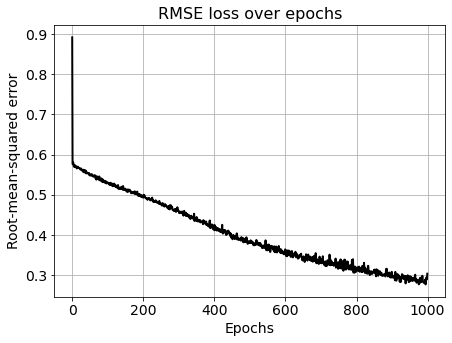

In [19]:
'''
Va bajando mucho el RMSE con las epochs, incluso podriamos probar mas epochs
'''
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

### Predictions
Note that the model was fitted only with the `trainX` and `trainY` data. 

In [27]:
trainX

array([[ 1.12152594,  0.48984886,  0.2001986 ,  0.88202617],
       [ 0.9356969 ,  1.12152594,  0.48984886,  0.2001986 ],
       [-0.48564405,  0.9356969 ,  1.12152594,  0.48984886],
       ...,
       [ 1.3982905 ,  1.18968785,  0.15138804,  1.44883844],
       [ 0.15490176,  1.3982905 ,  1.18968785,  0.15138804],
       [ 1.18327014,  0.15490176,  1.3982905 ,  1.18968785]])

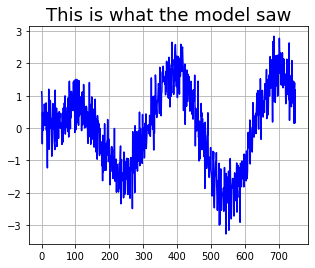

In [31]:
plt.figure(figsize=(5,4))
plt.title("This is what the model saw",fontsize=18)
# Saca todos los valores de train, la primera columna
plt.plot(trainX[:,0],c='blue')
plt.grid(True)
plt.show()

In [19]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
predicted = np.concatenate((trainPredict,testPredict),axis=0)

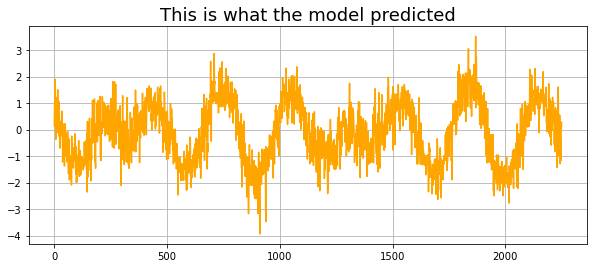

In [20]:
plt.figure(figsize=(10,4))
plt.title("This is what the model predicted",fontsize=18)
plt.plot(testPredict,c='orange')
plt.grid(True)
plt.show()

### Comparing it with the ground truth (test set)

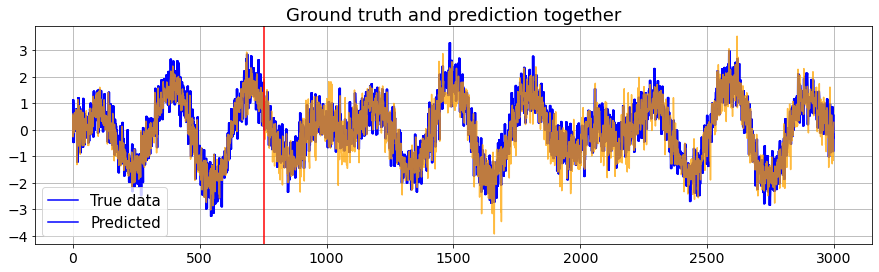

In [21]:
index = df2.index.values
plt.figure(figsize=(15,4))
plt.title("Ground truth and prediction together",fontsize=18)
plt.plot(index,df2,c='blue')
plt.plot(index,predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(df.index[Tp], c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### How are the errors distributed?
The errors, or residuals, as they are called in a regression problem, can be plotted to see if they follow any specific distribution. In the generation process, we injected Gaussian noise, so we expect the error to follow the same pattern, _if the model has been able to fit to the real data correctly_.

In [22]:
'''
Si encontramos patrones raros en los residuos es porque el modelo no se ha ajustado
bien a los datos. Habria que probar otras configuraciones/modelos.
'''
error = predicted[Tp:N]-df2[Tp:N]
# Ravel elimina una dimension, lo aplana todo. Como flatten
error = np.array(error).ravel()

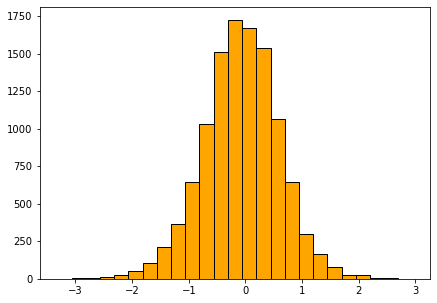

In [23]:
plt.figure(figsize=(7,5))
plt.hist(error,bins=25,edgecolor='k',color='orange')
plt.show()

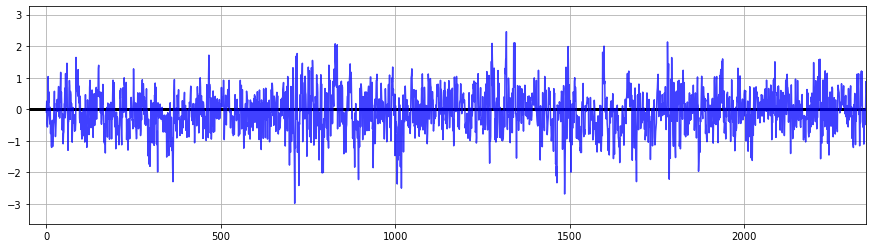

In [24]:
plt.figure(figsize=(15,4))
plt.plot(error,c='blue',alpha=0.75)
plt.hlines(y=0,xmin=-50,xmax=2400,color='k',lw=3)
plt.xlim(-50,2350)
plt.grid(True);

## Make the model better

Note, for running these experiments reasonably fast, we will fix the model size to be smaller than the model above. We will use a RNN layer with 32 neurons followed by a densely connected layer of 8 neurons.

### Varying the embedding/step size

In [25]:
def predictions(model,trainX,testX):
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    predicted = np.concatenate((trainPredict,testPredict),axis=0)
    
    return predicted

In [26]:
def plot_compare(predicted, df2):
    index = df2.index.values
    plt.figure(figsize=(15,4))
    plt.title("Ground truth and prediction together",fontsize=18)
    plt.plot(index,df2,c='blue')
    plt.plot(index,predicted,c='orange',alpha=0.75)
    plt.legend(['True data','Predicted'],fontsize=15)
    plt.axvline(df2.index[Tp], c="r")
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [27]:
def prepare_data(step=4):
    df2 = df.copy()
    emb_size = step
    for i in range(1, emb_size+1):
        df2['lag' + str(i)] = df2['Data'].shift(i)

    df2.dropna(inplace=True)
    df2.reset_index(drop=True, inplace=True)

    values = df2.values

    trainX,trainY = values[0:Tp-emb_size ,1:],values[0:Tp-emb_size ,0],
    testX,testY = values[Tp-emb_size:N-emb_size,1:], values[Tp-emb_size:N-emb_size,0]
    
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    return trainX,testX,trainY,testY,df2

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def errors(testX, testY):
    y_true = testY
    y_pred = model.predict(testX)
    return mean_absolute_error(y_true=y_true, y_pred=y_pred)

Embedding size: 2
MAE: 0.4654721074597999
----------------------------------------------------------------------------------------------------


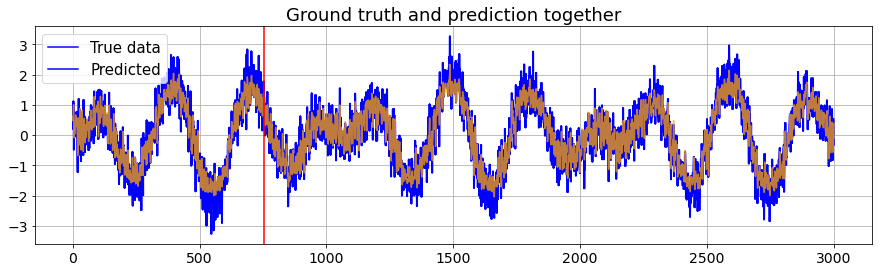


Embedding size: 4
MAE: 0.43278571279155525
----------------------------------------------------------------------------------------------------


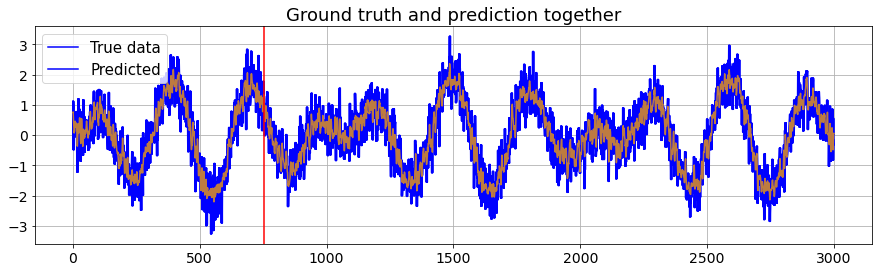


Embedding size: 6
MAE: 0.42764905348186816
----------------------------------------------------------------------------------------------------


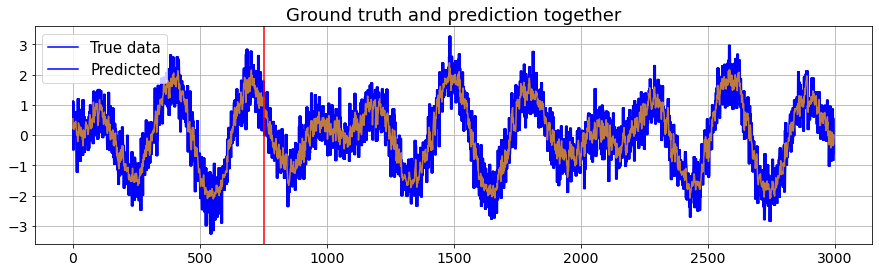


Embedding size: 8
MAE: 0.4353789516578771
----------------------------------------------------------------------------------------------------


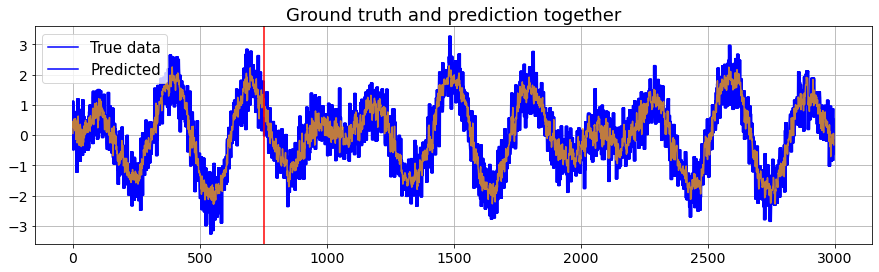


Embedding size: 10
MAE: 0.4421964052970347
----------------------------------------------------------------------------------------------------


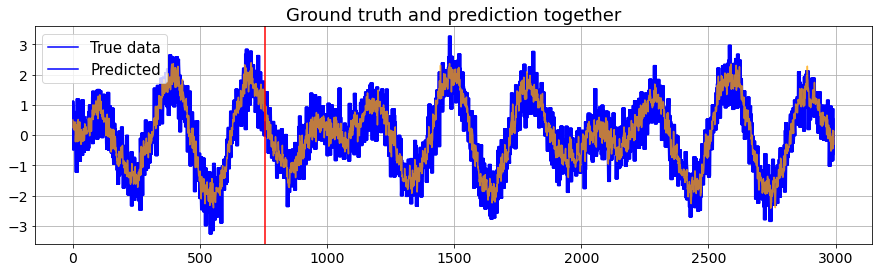


Embedding size: 12
MAE: 0.438454028332675
----------------------------------------------------------------------------------------------------


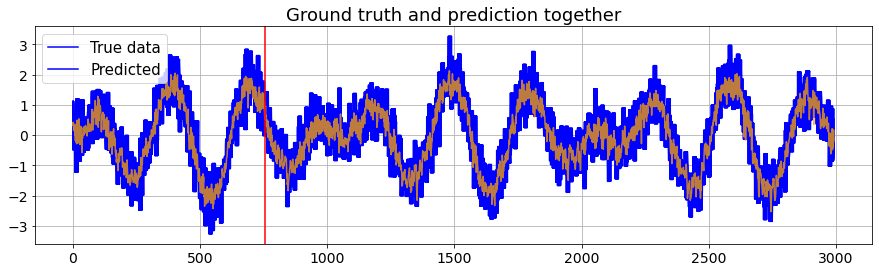

In [29]:
'''
Parece que cuanto mayor es la ventana, peor le está viniendo al modelo
Mas ruido le mete. Tb es cierto, para 100 epochs
'''
for s in [2,4,6,8,10,12]:
    trainX,testX,trainY,testY,df2 = prepare_data(s)
    model = build_simple_rnn(num_units=32,num_dense=8,embedding=s)
    batch_size=16
    num_epochs = 100
    model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size,
          verbose=0)
    preds = predictions(model,trainX,testX)
    print("Embedding size: {}".format(s))
    print("MAE:", errors(testX, testY))
    print("-"*100)
    plot_compare(preds, df2)
    print()

### Number of epochs

Ran for 100 epochs
MAE: 0.43089042750129997
----------------------------------------------------------------------------------------------------


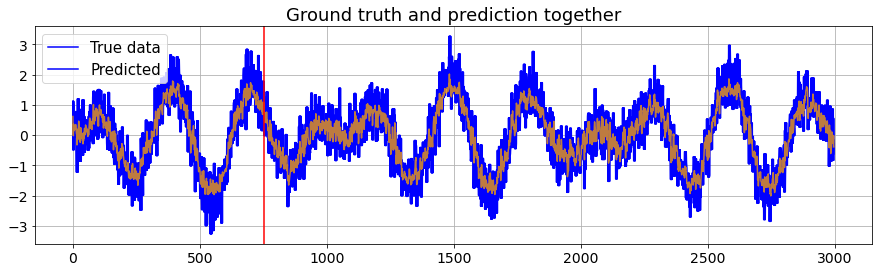


Ran for 200 epochs
MAE: 0.43052896502634685
----------------------------------------------------------------------------------------------------


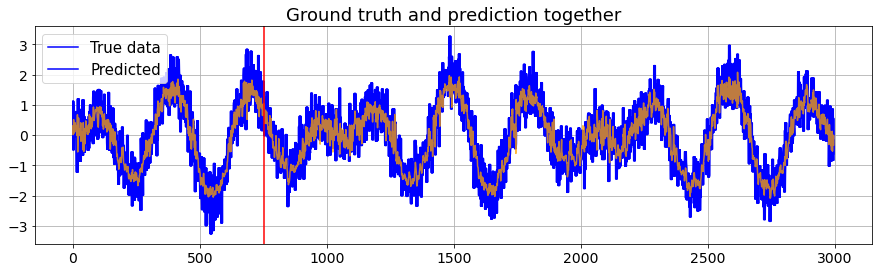


Ran for 300 epochs
MAE: 0.4478436134523957
----------------------------------------------------------------------------------------------------


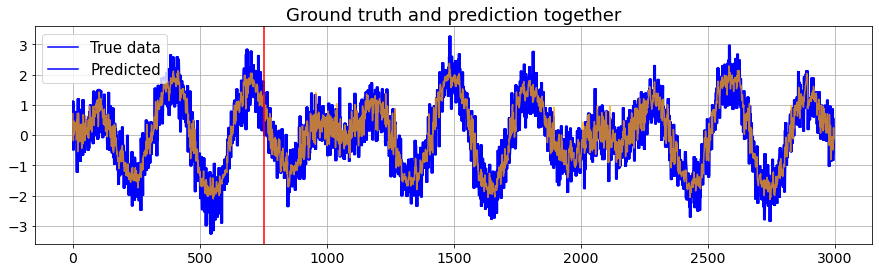


Ran for 400 epochs
MAE: 0.4628343757232584
----------------------------------------------------------------------------------------------------


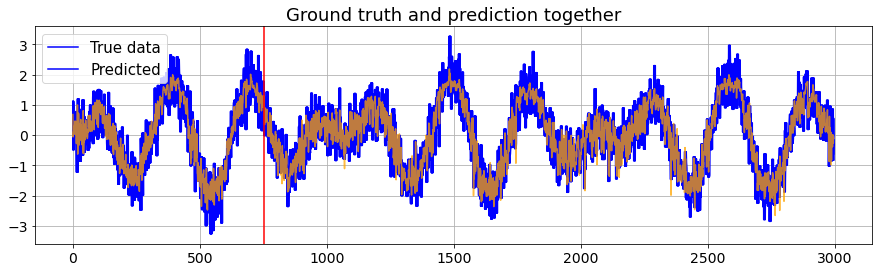


Ran for 500 epochs
MAE: 0.46116611795211043
----------------------------------------------------------------------------------------------------


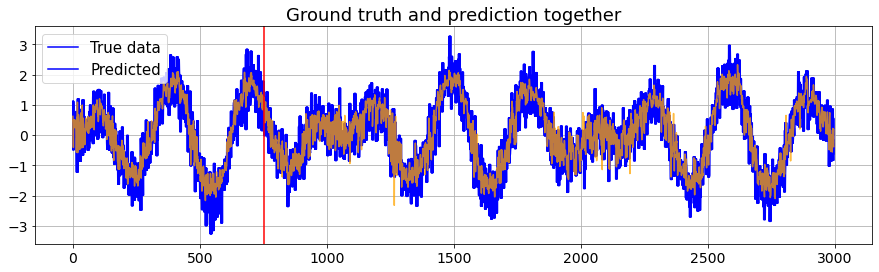

In [30]:
'''
Probemos ahora con una ventana grande (8), y unas cuantas epochs mas
'''
for e in [100,200,300,400,500]:
    trainX, testX, trainY, testY, df2 = prepare_data(6)
    model = build_simple_rnn(num_units=32,num_dense=8,embedding=6)
    batch_size=16
    num_epochs = e
    model.fit(trainX,trainY, 
          epochs=e, 
          batch_size=batch_size,
          verbose=0)
    preds = predictions(model,trainX,testX)
    print("Ran for {} epochs".format(e))
    print("MAE:", errors(testX, testY))
    print("-"*100)
    plot_compare(preds, df2)
    print()

### Batch size

Ran with batch size: 4
MAE: 0.4755104817725223
----------------------------------------------------------------------------------------------------


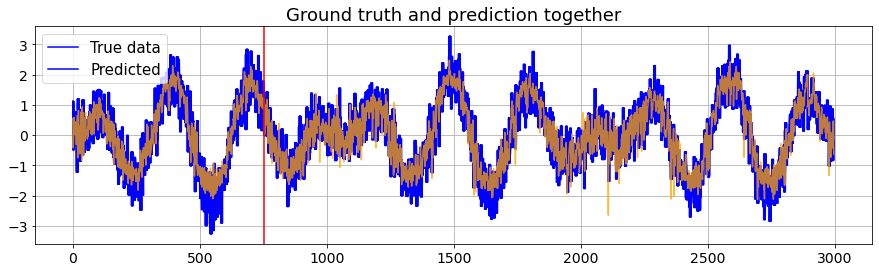


Ran with batch size: 8
MAE: 0.4611674336766553
----------------------------------------------------------------------------------------------------


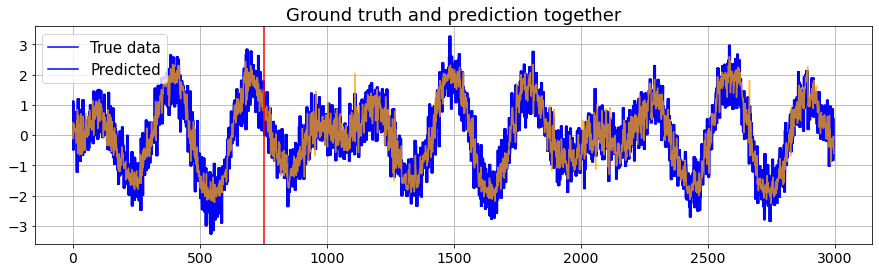


Ran with batch size: 16
MAE: 0.4492358700177486
----------------------------------------------------------------------------------------------------


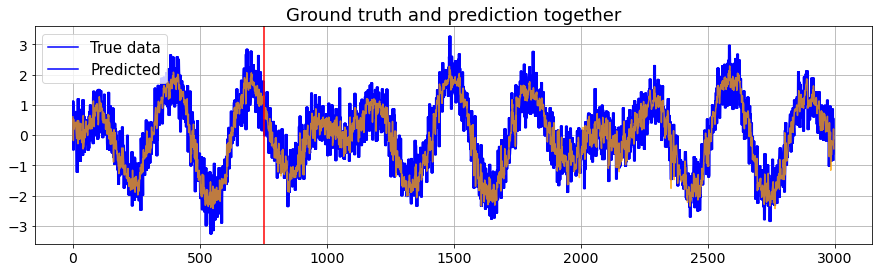


Ran with batch size: 32
MAE: 0.4330283499044209
----------------------------------------------------------------------------------------------------


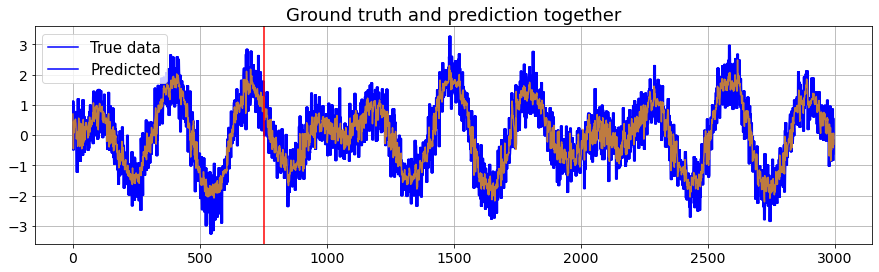


Ran with batch size: 64
MAE: 0.4269606436354416
----------------------------------------------------------------------------------------------------


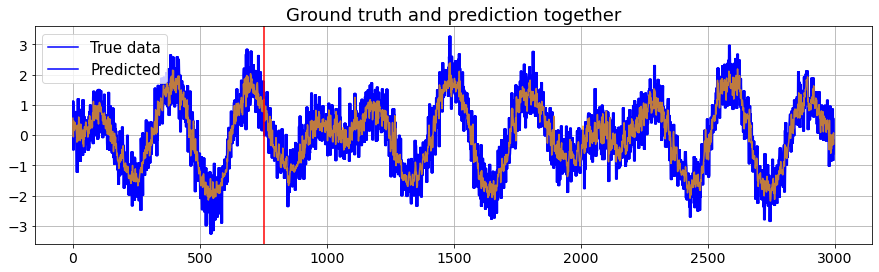

In [31]:
for b in [4,8,16,32,64]:
    trainX,testX,trainY,testY, df2 = prepare_data(6)
    model = build_simple_rnn(num_units=32,num_dense=8,embedding=6)
    batch_size=b
    num_epochs = 250
    model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=b,
          verbose=0)
    preds = predictions(model,trainX,testX)
    print("Ran with batch size: {}".format(b))
    print("MAE:", errors(testX, testY))
    print("-"*100)
    plot_compare(preds, df2)
    print()

### Summary

Clearly, following trends were observed,

- Too small embedding size is not useful but a very long embedding is also not effective. An embedding of 8 looks good for this data.
- More epochs are not always better. Probably we are suffering overfitting
- A batch size of 32 or 64 looks optimal.

Ultimately, an exhaustive hyperparameter tuning is needed for the best overall performance.